# Selecting sample and producing municipal measures as Rt and CFR 

In [94]:
from math import exp

import epyestim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from epyestim import covid19
from scipy.stats import gamma, lognorm

## Loading data

In [95]:
df_municipalities = pd.read_csv('../data/df_municpal.csv')

In [96]:
df_sim_municipal = pd.read_csv('../data/df_sim_municipal.csv')
df_sim_municipal.DATA = pd.to_datetime(df_sim_municipal.DATA)

In [97]:
df_srag_municipal = pd.read_csv('../data/df_ts_srag_municipal.csv')
df_srag_municipal.DATA = pd.to_datetime(df_srag_municipal.DATA)

In [98]:
df_srag_municipal = df_srag_municipal.rename(columns = {'NOVOS_CASOS': 'NOVOS_CASOS_SRAG'})

In [99]:
df_monitoring_panel_municipal = pd.read_csv('../data/df_ts_monitoring_panel_treated_municipal.csv')
df_monitoring_panel_municipal.data = pd.to_datetime(df_monitoring_panel_municipal.data)
df_monitoring_panel_municipal = df_monitoring_panel_municipal.rename(columns= {'data': 'DATA'})

## Treating data

### Removing invalid municipality

In [100]:
df_srag_municipal = df_srag_municipal[df_srag_municipal.CODIGO_MUNICIPIO_6 != 999999].copy()

### Treating data from Brasília that is splited by satelity cities in SRAG database

In [101]:
# Filter rows where CODIGO_MUNICIPIO_6 starts with 53
filtered_df = df_srag_municipal[df_srag_municipal['CODIGO_MUNICIPIO_6'].astype(str).str.startswith('53')]

# Group by 'DATA' and sum the 'NOVOS_CASOS_SRAG'
summed_df = filtered_df.groupby('DATA')['NOVOS_CASOS_SRAG'].sum().reset_index()

# Update df_srag_municipal for CODIGO_MUNICIPIO_6 = 530010
df_srag_municipal.loc[df_srag_municipal['CODIGO_MUNICIPIO_6'] == 530010, 'NOVOS_CASOS_SRAG'] = summed_df['NOVOS_CASOS_SRAG'].values

# Drop rows with CODIGO_MUNICIPIO_6 starting with 53 (excluding CODIGO_MUNICIPIO_6 = 530010)
df_srag_municipal = df_srag_municipal[(~df_srag_municipal['CODIGO_MUNICIPIO_6'].astype(str).str.startswith('53')) | (df_srag_municipal['CODIGO_MUNICIPIO_6'] == 530010)]

# Reset index
df_srag_municipal.reset_index(drop=True, inplace=True)

### Merging data frames

In [102]:
df = df_srag_municipal.merge(df_sim_municipal[['DATA', 'CODIGO_MUNICIPIO_6', 'OBITOS_NOVOS', 'OBITOS', 'OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS', 'TAXA_OBITOS_NOVOS', 'TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS', 'TAXA_OBITOS']], how='left', on=['DATA', 'CODIGO_MUNICIPIO_6'])

In [103]:
df = df.merge(df_monitoring_panel_municipal[['DATA', 'CODIGO_MUNICIPIO_6', 'casosNovos', 'casosAcumulado', 'CASOS_NOVOS_MEDIA_MOVEL_7_DIAS']], how='left', on=['DATA', 'CODIGO_MUNICIPIO_6'])

In [104]:
df = df.merge(df_municipalities[['CODIGO_MUNICIPIO_6','MUNICIPIO', 'SIGLA_ESTADO', 'ESTADO', 'REGIAO', 'POPULACAO_2022']], how='left', on=['CODIGO_MUNICIPIO_6'])

### Fill null values

In [107]:
df = df.fillna(0)

In [108]:
df.CODIGO_MUNICIPIO_6.unique()

array([110001, 110002, 110003, ..., 522220, 522230, 530010])

In [109]:
df.isna().any()

DATA                                    False
CODIGO_MUNICIPIO_6                      False
NOVOS_CASOS_SRAG                        False
OBITOS_NOVOS                            False
OBITOS                                  False
OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS         False
TAXA_OBITOS_NOVOS                       False
TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS    False
TAXA_OBITOS                             False
casosNovos                              False
casosAcumulado                          False
CASOS_NOVOS_MEDIA_MOVEL_7_DIAS          False
MUNICIPIO                               False
SIGLA_ESTADO                            False
ESTADO                                  False
REGIAO                                  False
POPULACAO_2022                          False
dtype: bool

## Selecting sample

In [110]:
df = df[df.POPULACAO_2022 > 500000].copy()

In [112]:
df[['MUNICIPIO', 'ESTADO']].drop_duplicates()

,MUNICIPIO,ESTADO
116550,Manaus,Amazonas
177450,Belém,Pará
666750,São Luís,Maranhão
926100,Teresina,Piauí
996450,Fortaleza,Ceará
1221150,Natal,Rio Grande do Norte
1403850,João Pessoa,Paraíba
1629600,Jaboatão dos Guararapes,Pernambuco
1675800,Recife,Pernambuco
1780800,Maceió,Alagoas


## Estimating effective reproduction number for national time series


In [113]:
#Bi, Qifang, et al. "Epidemiology and transmission of COVID-19 in 391 cases and 1286 of their close contacts in Shenzhen, China: a retrospective cohort study." The Lancet infectious diseases 20.8 (2020): 911-919.
# Gamma distribution with serial interval mean equal to 6.36 days, gamma(a=2.29, b=0.36)
standard_serial_inteval_distribution = epyestim.discrete_distrb(gamma(a=2.29, scale=1/0.36))

#Bi, Qifang, et al. "Epidemiology and transmission of COVID-19 in 391 cases and 1286 of their close contacts in Shenzhen, China: a retrospective cohort study." The Lancet infectious diseases 20.8 (2020): 911-919.
# Lognormal distribution with incabation mean equal to 5.93 days, Lognormal(mu=1.57, sigma²=0.42)
incubation_time_distribution = epyestim.discrete_distrb(lognorm(scale=exp(1.57), s=0.65))

# Chagas, Eduarda TC, et al. "Effects of population mobility on the COVID-19 spread in Brazil." PloS one 16.12 (2021): e0260610.
# Exponential distribution with delay mean equal to 10.85 days, gamma(a=12.26, b=1.13)
# Tip to calulate parameters: https://www.quora.com/How-can-I-calculate-a-gamma-distribution-using-mean-and-SD
# delay_onset_to_notification_distribution = epyestim.discrete_distrb(gamma(a=12.26, scale=1/1.13))

#Barros, Gabriela Pereira, et al. "Estimation of Reproduction Number for Covid-19 with Statistical Correction of Notifications Delay." IEEE Latin America Transactions 20.7 (2022): 1085-1091.
#Gamma distribution for BH city with mean equal 6.56 days SD 5.34, gamma(a=1.51, b=0.23)
delay_onset_to_notification_distribution = epyestim.discrete_distrb(gamma(a=1.51, scale=1/0.23))

# Distribution resultant of convolution incubation_time_distribution and delay_onset_to_notification_distribution.
# Represent delay of infection to notification with delay mean equal to 12.5 days.
delay_infecton_to_notification_distribution = np.convolve(incubation_time_distribution, delay_onset_to_notification_distribution)

# Verity, Robert, et al. "Estimates of the severity of coronavirus disease 2019: a model-based analysis." The Lancet infectious diseases 20.6 (2020): 669-677.
# Gamma distribution with delay mean equal to 18.8 days
mean_days_delay_onset_to_death = 18.8  # mean days onset to death.
s_death = 0.45
shape_death = 1/(s_death**2)
scale_death= mean_days_delay_onset_to_death * s_death ** 2
delay_onset_to_death_distribution = epyestim.discrete_distrb(gamma(a=shape_death, scale=scale_death))

# Distribution resultant of convolution incubation_time_distribution and delay_onset_to_notification_distribution.
# Represent delay of infection to notification with delay mean equal to 24.02 days.
delay_infecton_to_death_distribution = np.convolve(incubation_time_distribution, delay_onset_to_death_distribution)

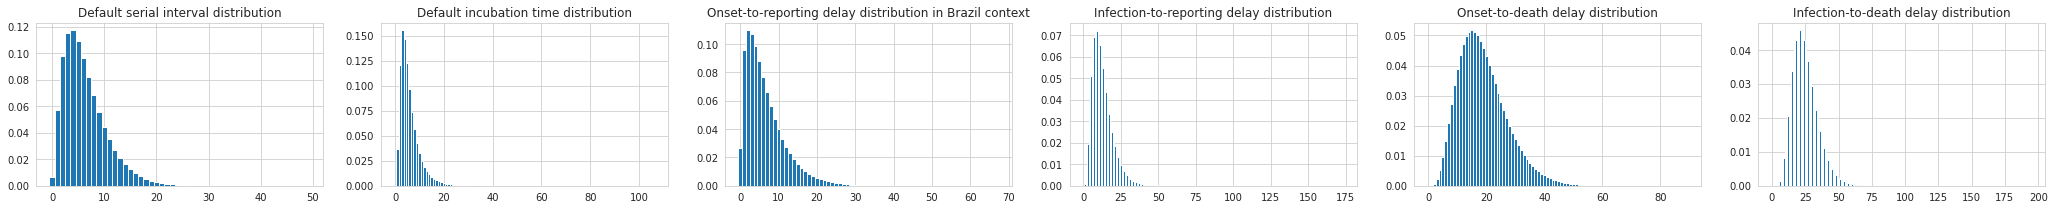

In [114]:
fig, axs = plt.subplots(1, 6, figsize=(36,3))

axs[0].bar(range(len(standard_serial_inteval_distribution)), standard_serial_inteval_distribution, width=1)
axs[1].bar(range(len(incubation_time_distribution)), incubation_time_distribution, width=1)
axs[2].bar(range(len(delay_onset_to_notification_distribution)), delay_onset_to_notification_distribution, width=1)
# axs[3].bar(range(50), delay_infecton_to_notification_distribution[:50], width=1)
axs[3].bar(range(len(delay_infecton_to_notification_distribution)), delay_infecton_to_notification_distribution, width=1)
axs[4].bar(range(len(delay_onset_to_death_distribution)), delay_onset_to_death_distribution, width=1)
axs[5].bar(range(len(delay_infecton_to_death_distribution)), delay_infecton_to_death_distribution, width=1)

axs[0].set_title('Default serial interval distribution')
axs[1].set_title('Default incubation time distribution')
axs[2].set_title('Onset-to-reporting delay distribution in Brazil context')
axs[3].set_title('Infection-to-reporting delay distribution')
axs[4].set_title('Onset-to-death delay distribution')
axs[5].set_title('Infection-to-death delay distribution')
plt.show()

In [115]:
window_days_onset_to_death = round(mean_days_delay_onset_to_death)
window_days_onset_to_death

19

In [116]:
df_national = pd.read_csv('data/output/df_national.csv')

In [117]:
survival_rate = (df_national.CASOS_NOVOS_PAINEL.sum() / df_national.OBITOS_NOVOS_SIM.sum())
survival_rate

51.7129300540739

### SRAG

In [118]:
df_with_reproduction_number = pd.DataFrame()

for id_municipality in df.CODIGO_MUNICIPIO_6.unique():
    print(id_municipality)
    df_municipality = df[df.CODIGO_MUNICIPIO_6 == id_municipality]
    df_cases_srag = df_municipality.set_index('DATA')['NOVOS_CASOS_SRAG']
    
    # Cori, A., Ferguson, N. M., Fraser, C., & Cauchemez, S. (2013). A new framework and software to estimate time-varying reproduction numbers during epidemics. American journal of epidemiology, 178(9), 1505-1512.
    # https://github.com/lo-hfk/epyestim
    df_effective_reproduction_number_srag = covid19.r_covid(df_cases_srag, smoothing_window = 28, r_window_size = 14, auto_cutoff=True, n_samples=100, delay_distribution=incubation_time_distribution, gt_distribution=standard_serial_inteval_distribution, a_prior=9.9, b_prior=1/9.25)
    
    df_effective_reproduction_number_srag = df_effective_reproduction_number_srag.reset_index()
    df_effective_reproduction_number_srag = df_effective_reproduction_number_srag.rename(columns={'index': 'DATA', 'R_mean': 'NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA', 'R_var': 'NUMERO_REPRODUCAO_EFETIVO_SRAG_VARIANCIA', 'Q0.025': 'NUMERO_REPRODUCAO_EFETIVO_SRAG_QUANTIL_0.025', 'Q0.5': 'NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIANA', 'Q0.975': 'NUMERO_REPRODUCAO_EFETIVO_SRAG_QUANTIL_0.975' })    
    df_effective_reproduction_number_srag = df_effective_reproduction_number_srag.drop(columns=['cases'])
    df_effective_reproduction_number_srag['CODIGO_MUNICIPIO_6'] = id_municipality
    
    df_with_reproduction_number = pd.concat([df_with_reproduction_number, df_effective_reproduction_number_srag])
    
df = df.merge(df_with_reproduction_number, how='left', on=['DATA', 'CODIGO_MUNICIPIO_6'])

130260
150140
211130
221100
230440
240810
250750
260790
261160
270430
280030
291080
292740
310620
311860
313670
317020
320500
330170
330350
330455
330490
350950
351880
353440
354340
354780
354870
354990
355030
355220
410690
411370
420540
420910
431490
500270
510340
520140
520870
530010


### Cases

In [119]:
df_with_reproduction_number = pd.DataFrame()

for id_municipality in df.CODIGO_MUNICIPIO_6.unique():
    print(id_municipality)
    df_municipality = df[df.CODIGO_MUNICIPIO_6 == id_municipality].copy()
    df_municipality.loc[df_municipality.casosNovos < 0, 'casosNovos'] = 0
    df_cases = df_municipality.set_index('DATA')['casosNovos'].dropna()
    
    df_effective_reproduction_number = covid19.r_covid(df_cases, smoothing_window = 28, r_window_size = 14, auto_cutoff=True, n_samples=100, delay_distribution=delay_infecton_to_notification_distribution, gt_distribution=standard_serial_inteval_distribution, a_prior=9.9, b_prior=1/9.25)
    
    df_effective_reproduction_number = df_effective_reproduction_number.reset_index()
    df_effective_reproduction_number = df_effective_reproduction_number.rename(columns={'index': 'DATA', 'R_mean': 'NUMERO_REPRODUCAO_EFETIVO_MEDIA', 'R_var': 'NUMERO_REPRODUCAO_EFETIVO_VARIANCIA', 'Q0.025': 'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.025', 'Q0.5': 'NUMERO_REPRODUCAO_EFETIVO_MEDIANA', 'Q0.975': 'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.975' })
    df_effective_reproduction_number = df_effective_reproduction_number.drop(columns=['cases'])
    df_effective_reproduction_number['CODIGO_MUNICIPIO_6'] = id_municipality
    
    df_with_reproduction_number = pd.concat([df_with_reproduction_number, df_effective_reproduction_number])
    
df = df.merge(df_with_reproduction_number, how='left', on=['DATA', 'CODIGO_MUNICIPIO_6'])

130260
150140
211130
221100
230440
240810
250750
260790
261160
270430
280030
291080
292740
310620
311860
313670
317020
320500
330170
330350
330455
330490
350950
351880
353440
354340
354780
354870
354990
355030
355220
410690
411370
420540
420910
431490
500270
510340
520140
520870
530010


### Reproduction number from deaths

In [120]:
df.columns

Index(['DATA', 'CODIGO_MUNICIPIO_6', 'NOVOS_CASOS_SRAG', 'OBITOS_NOVOS',
       'OBITOS', 'OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS', 'TAXA_OBITOS_NOVOS',
       'TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS', 'TAXA_OBITOS', 'casosNovos',
       'casosAcumulado', 'CASOS_NOVOS_MEDIA_MOVEL_7_DIAS', 'MUNICIPIO',
       'SIGLA_ESTADO', 'ESTADO', 'REGIAO', 'POPULACAO_2022',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_VARIANCIA',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_QUANTIL_0.025',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIANA',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_QUANTIL_0.975',
       'NUMERO_REPRODUCAO_EFETIVO_MEDIA',
       'NUMERO_REPRODUCAO_EFETIVO_VARIANCIA',
       'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.025',
       'NUMERO_REPRODUCAO_EFETIVO_MEDIANA',
       'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.975'],
      dtype='object')

In [121]:
df_with_reproduction_number = pd.DataFrame()

for id_municipality in df.CODIGO_MUNICIPIO_6.unique():
    print(id_municipality)
    df_municipality = df[df.CODIGO_MUNICIPIO_6 == id_municipality].copy()
    
    df_municipality['CASOS_INICIO_SINTOMAS_ESTIMADOS'] = df_municipality['OBITOS_NOVOS'] * survival_rate
    df_municipality['CASOS_INICIO_SINTOMAS_ESTIMADOS'] = df_municipality['CASOS_INICIO_SINTOMAS_ESTIMADOS'].rolling(window=window_days_onset_to_death, min_periods=1).mean().shift(-(window_days_onset_to_death - 1))
    
    df_cases = df_municipality.set_index('DATA')['CASOS_INICIO_SINTOMAS_ESTIMADOS'].dropna()
    
    df_effective_reproduction_number_estimated_cases = covid19.r_covid(df_cases, smoothing_window = 28, r_window_size = 14, auto_cutoff=True, n_samples=100, delay_distribution=incubation_time_distribution, gt_distribution=standard_serial_inteval_distribution, a_prior=9.9, b_prior=1/9.25)

    df_effective_reproduction_number_estimated_cases = df_effective_reproduction_number_estimated_cases.reset_index()
    df_effective_reproduction_number_estimated_cases = df_effective_reproduction_number_estimated_cases.rename(columns={'index': 'DATA', 'R_mean': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA', 'R_var': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_VARIANCIA', 'Q0.025': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.025', 'Q0.5': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIANA', 'Q0.975': 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.975'})
    df_effective_reproduction_number_estimated_cases = df_effective_reproduction_number_estimated_cases.drop(columns=['cases'])
    df_effective_reproduction_number_estimated_cases['CODIGO_MUNICIPIO_6'] = id_municipality
    
    df_with_reproduction_number = pd.concat([df_with_reproduction_number, df_effective_reproduction_number_estimated_cases])
    
df = df.merge(df_with_reproduction_number, how='left', on=['DATA', 'CODIGO_MUNICIPIO_6'])

130260
150140
211130
221100
230440
240810
250750
260790
261160
270430
280030
291080
292740
310620
311860
313670
317020
320500
330170
330350
330455
330490
350950
351880
353440
354340
354780
354870
354990
355030
355220
410690
411370
420540
420910
431490
500270
510340
520140
520870
530010


## Case fatality rate

### Municipal data

In [122]:
df['TAXA_FATALIDADE'] = (
    df.groupby('CODIGO_MUNICIPIO_6')
    .apply(lambda group: group['OBITOS_NOVOS'].rolling(window=7,min_periods=1).mean() / group['CASOS_NOVOS_MEDIA_MOVEL_7_DIAS'].shift(12) * 100)
    .reset_index(level=0, drop=True)
)

## Saving data


In [123]:
df.to_csv('../data/df_municipal_epidemic_parameters_sample.csv')

In [124]:
df.head()

,DATA,CODIGO_MUNICIPIO_6,NOVOS_CASOS_SRAG,OBITOS_NOVOS,OBITOS,OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS,TAXA_OBITOS_NOVOS,TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS,TAXA_OBITOS,casosNovos,...,NUMERO_REPRODUCAO_EFETIVO_VARIANCIA,NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.025,NUMERO_REPRODUCAO_EFETIVO_MEDIANA,NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.975,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_VARIANCIA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.025,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIANA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.975,TAXA_FATALIDADE
0,2020-02-16,130260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-17,130260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-18,130260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-19,130260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-20,130260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
df.shape

(43050, 33)

In [126]:
df.TAXA_FATALIDADE.describe().round(2)

count    41160.00
mean          inf
std           NaN
min       -825.00
25%          0.59
50%          1.97
75%          4.55
max           inf
Name: TAXA_FATALIDADE, dtype: float64